In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, semisupervised_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

# Import the census data set

In [2]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

# Problem setup

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 50
K = 5  # Folds for semisupervised

# True mean (computed on all labels)
true_theta = Y_total.mean()

# Construct intervals

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        # PPI interval
        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Semisupervised interval
        semisupervised_ci = semisupervised_mean_ci(
            _X, _Y, _X_unlabeled, K, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Baseline",  # Semisupervised baseline
                        "n": n,
                        "lower": semisupervised_ci[0],
                        "upper": semisupervised_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


# Plot results

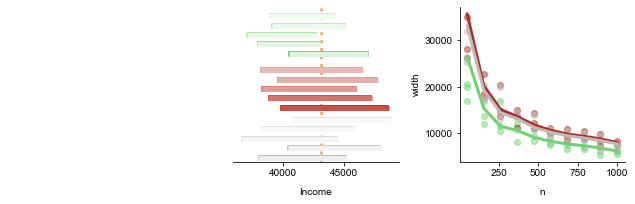

In [5]:
make_plots(
    df,
    "./plots/semisupervised_census_income.pdf",
    n_idx=-1,
    intervals_xlabel="Income",
    true_theta=true_theta,
)

In [6]:
# Find n such that we reject H0: income < 30K with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=0.05)
        if ppi_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_semisupervised(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]

        semisupervised_ci = semisupervised_mean_ci(
            _X, _Y, _X_unlabeled, K, alpha=0.05
        )

        if semisupervised_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_mean_ci(_Y, alpha=0.05)

        if classical_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 1, 5000, xtol=1))
n_semisupervised = int(brentq(_to_invert_semisupervised, 1, 5000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 1, 5000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The semisupervised test requires n={n_semisupervised} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

/Users/angelopoulos/Code/working/ppi_py/ppi_py/baselines.py:65: RuntimeWarning: Mean of empty slice.
  * (beta_fold.dot(Vhat_fold.T) * epsilon_hats[fold_indices]).mean()
/Users/angelopoulos/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/angelopoulos/Code/working/ppi_py/ppi_py/baselines.py:68: RuntimeWarning: Mean of empty slice.
  2 * beta_fold.dot(Vhat_fold.T).mean()


The PPI test requires n=118 labeled data points to reject the null.
The semisupervised test requires n=201 labeled data points to reject the null.
The classical test requires n=226 labeled data points to reject the null.
